# Recurrent NN (LSTM) on equation of motion
The goal is to predict the trajectories of particles in a gravity field with help of a neuronal network. 
Therefore training data is generated by solving the equation of motion of the particle in the gravity field by solving numerically the differential equation. Later a recurrent neuronal network is trained on this data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy as sc
from time import strftime
import tensorflow as tf
import tensorflow.keras as ks

np.random.seed(42) # for reproducibility

# Init of tensorboard
def log_dir(sub_dir='logs'):
    '''Function returns directory to store current tensorflow training log.
    Parameter:
        sub_dir <str> subdirectory to collect logs in
        
    Return:
        <path> Path composed of sub_dir and encoded system time
    '''
    return os.path.join(sub_dir, strftime('training_%Y_%m_%d_%H_%M_S'))
%load_ext tensorboard

2024-05-30 12:00:02.354865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 12:00:02.729377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 12:00:02.731747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 12:00:04.349510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Defining classes of space body and space particle
### This will facilitate defining and the solving of equation of motion by Runge-Kutta method for a particle in the gravity field of one or more space bodies.

Physical problem: Finding trajectory of particle P_0. Forces on particle 0 are gravity from two bodies B_1, B_2. 
While B_1 rests in center of coordinate system, while B_2 moves around B_1 on a circular trajectory.

In [2]:
# Defining a class that holds all information about a particle or body
class space_body():
    '''Class that holds position and mass in properties. Returns distance to other objects
    by calling method "dist_to_object()" Returns array with own positions by calling method ".pos()".
    Methods:
        .dist_to_object(position) Returns distance to objects located at position, position: 2D list-like
        .pos() Returns 2D list-like of own position
        .normalized_diff_vector(position) Returns normalized differential vector pointing to object located at
                position, position: 2D list-like'''
    def __init__(self, position, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.m = mass
        self.r = radius
        
    def pos(self):
        return np.array([self.x, self.y])
        
    def dist_to_object(self, position):
        return np.sqrt((self.x - position[0])**2 + (self.y - position[1])**2)
    
    def normalized_diff_vector(self, position):
        abs_value = np.sqrt((position[0] - self.x)**2 + (position[1] - self.y)**2)
        return np.array([position[0] - self.x, position[1] - self.y]) / abs_value
    
# Defining a class that hold additionally its velocity
class space_particle(space_body):
    '''Class that holds position, mass and velocity in properties. 
    Additional properties t_series, pos_series, vel_series store result of integration of equation of motion:
    t: Stores time steps
    pos: stores position vectors as 2D array, shape (timesteps, 2)
    vel: stores velocity vectors as 2D array, shape (timesteps, 2)
    Returns distance to other objects by calling method "dist_to_object()".
    Integrates equation of motion with property .integrate(), see details in doc string of method'''
    
    def __init__(self, position, velocity, mass, radius):
        self.x = position[0]
        self.y = position[1]
        self.v_x = velocity[0]
        self.v_y = velocity[1]
        self.m = mass
        self.r = radius
        self.solution = pd.DataFrame()

    def RK_dy_dt(self, t, y, G, bodies):
        '''Defining right hand side of motions of equations, to be able to pass them to Runge Kutta solver
        Force on P_0 by B_1 causes acceleration. Velocities are easily obtained from vector y.'''
        # Writing new values to position and velocity of P_0 object
        self.x = y[0]
        self.y = y[1]
        self.v_x = y[2]
        self.v_y = y[3]
        
        # numeric values to sum up acceleration for x- and y-coordinate for every body, initialized with 0
        acc_x = 0
        acc_y = 0
        for i, body in enumerate(bodies):
            # Calculating absolut value of acceleration caused by gravitational force of each body on P_0
            if self.dist_to_object(body.pos()) < 0.01: # If true: avoid division by zero
                abs_acc = G * body.m * 0.01**(-2)
            else:
                abs_acc = G * body.m * self.dist_to_object(body.pos())**(-2)
            # Calculate x-component of acceleration
            acc_x += np.array([1, 0]) @ self.normalized_diff_vector(body.pos()) * abs_acc
            # Calculate y-component of acceleration
            acc_y += np.array([0, 1]) @ self.normalized_diff_vector(body.pos()) * abs_acc
        return [self.v_x, self.v_y, acc_x, acc_y]
    
    def integrate(self, G, bodies, t_span, n_points, rtol=1E-5):
        '''Integrate equation of motion in presence of Body. 
        Parameters:
            G: gravitational constant
            Body: space_body object, gravitation force of this body will act on particle
            t_span: tuple of two numerical values, defining time interval of integration
            n_points: integer defining number of steps in result of integration
            rtol: numerical value defining tolerance for Runge-Kutta solver

        Has no return value, fills property DataFrame "solution" with result of integration'''
        integration = sc.integrate.solve_ivp(
            lambda t, y: self.RK_dy_dt(t, y, G, bodies), t_span=t_span, 
            y0=np.array([self.x, self.y, self.v_x, self.v_y]), 
            t_eval=np.linspace(t_span[0], t_span[1], n_points), rtol=1E-5
        )
        self.solution = self.solution.assign(
            t=integration.t,
            x=integration.y[0],
            y=integration.y[1],
            v_x=integration.y[2],
            v_y=integration.y[3]
        )
        return self
    
    def show_trajectory(self, bodies=None):
        '''Method to create an plot of trajectory (result of integration of equation of motion).
        Optional arguement "bodies", accepts list of space_body objects to be plottet additionally in plot'''
        fig, ax = plt.subplots()
        ax.set_xlabel('x-coordinate [a.u.]')
        ax.set_ylabel('y-coordinate [a.u.]')
        ax.set_aspect(aspect='equal', adjustable='box') # force same scale for both axes
        abs_max_axes = self.solution[['x', 'y']].abs().max().max() + 1# maximum of absolute values of coordinates x,y
        ax.set_xlim(-abs_max_axes, abs_max_axes)
        ax.set_ylim(-abs_max_axes, abs_max_axes)
        ax.scatter(self.solution.x, self.solution.y, c=self.solution.t, s=8)
        if bodies != None:
            for i, body in enumerate(bodies):
                # Draw n points on the radius of each space_body
                n = 50
                x_circle = np.array([body.r * np.sin(i*2*np.pi/n) for i in range(1, n+1)])
                y_circle = np.array([body.r * np.cos(i*2*np.pi/n) for i in range(1, n+1)])
                ax.scatter(body.x + x_circle, body.y + y_circle, c='k', s=12)
                
# Function to plot trajectories
def compare_trajectory(ax, *a):
    '''Function plots trajectories on axes, in order to compare trajectories visually.
    Parameters:
        ax <matplotlib.axes> Axes to plot the trajectories on.
        *a  have to be 2D arrays with shape (n, 2) with stored x- and y-positions
    Return:
        None
    '''
    ax.set_xlabel('x-coordinate [a.u.]')
    ax.set_ylabel('y-coordinate [a.u.]')
    ax.set_aspect(aspect='equal', adjustable='box') # force same scale for both axes
    # Find biggest absolute value in a
    abs_max_axes = 0
    for i, val in enumerate(a):
        if np.abs(val).max() > abs_max_axes:
            abs_max_axes = np.abs(val).max()
    # Enlarge biggest value found, and set boundaries of plot
    abs_max_axes += 0.1
    ax.set_xlim(-abs_max_axes, abs_max_axes)
    ax.set_ylim(-abs_max_axes, abs_max_axes)
    # Plot all trajectories
    for i, traj in enumerate(a):
        ax.scatter(traj.T[0], traj.T[1], s=8)
    return None

### Example: Two space_body act on space_particle P_0
Like a spaceship P_0 is travelling from body B_1 to body B_2

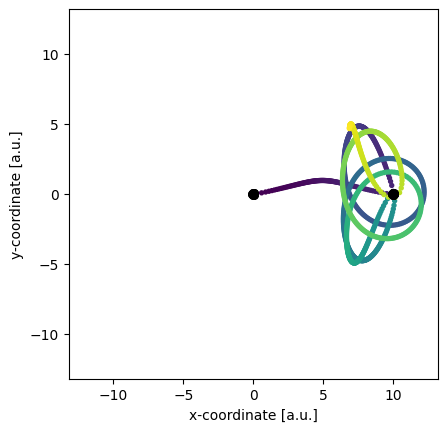

In [3]:
G = 1 # Gravitational constant

# Create body in center of coordinate system with big mass
B_1 = space_body(position=[0, 0], mass=1.0, radius=0.15)
# Create body in 10 unit distance along x from B_1
B_2 = space_body(position=[10, 0], mass=1.0, radius=0.15)

# Create particle that contains velocity, as well
P_0 = space_particle(position=[0.15, 0], velocity=[3.55, .455], mass=0.05, radius=0.05) 
# velocity=[3.55, .45]

# Integrate equation of motion in presence of B_1, B_2
P_0.integrate(G, [B_1, B_2], t_span=(0, 200), n_points=1000)
# Display result in a plot of trajectory
P_0.show_trajectory(bodies=[B_1, B_2])

## Generation of data for training and evaluation of Recurrent Neuronal Network

### Case here: Spaceship in vicinity of one body. (Like launching a satellite)

In [4]:
def gen_samples_launch_from_surface(n_samples, n_timesteps, 
                                    B=[space_body(position=(0, 0), mass=10, radius=0.15)],
                                    launch_pos=(0, 0.3), launch_velocity_x_window=(5, 8),
                                    launch_velocity_y_window=(0, 0), mass=0.1, radius=0.05, G=1):
    '''Generator will return trajectories, as calculated by solving the equation of motion, defined
    by the parameter set. The default parameter correspond to closed trajectories of a single particle
    (satellite) in the vicinity of a much bigger space body (planet). The trajectories vary, because
    different initial conditions are defined for launching velocity (uniform distribution in window)
    Parameters:
        n_samples <int> number of samples to generate
        n_timesteps <int> number of timesteps in every trajectory
        B <list of space_body instances> List holding all space bodies, which will act with their gravity
            on the space particle
        launch_pos <tuple of 2 floats> x and y coordinate of initial position of space particle
        launch_velocity_x_window <tuple of 2 floats> window in which uniformly distributed random numbers
            will be drawn to determin the initial velocity in x-coordinate
        launch_velocity_y_window <tuple of 2 floats> window in which uniformly distributed random numbers
            will be drawn to determin the initial velocity in y-coordinate
        mass <float> mass assigned to the space particles
        radius <float> radius assigned to the space particles
        G <float> gravitational constant [a.u.]
        
    Return:
        generator yielding the solved equation of motion of a space particle. 5 columns holding
        values for time_step, position x-coordinate, position y-coordinate, velocity x-coordinate,
        velocity y-coordinate.
    '''
    # Calculate span of defined velocity window    
    vel_x_span = launch_velocity_x_window[1]-launch_velocity_x_window[0]
    vel_y_span = launch_velocity_y_window[1]-launch_velocity_y_window[0]
    for i in range(n_samples):    
        yield (
            # Create instance of space particle, integrate its equation of motion and yield the solution
            space_particle(
                position=launch_pos, velocity=[
                    launch_velocity_x_window[0] + vel_x_span*np.random.random(),
                    launch_velocity_y_window[0] + vel_y_span*np.random.random()
                ], mass=mass, radius=radius
            )
            .integrate(G, B, t_span=(0, 1), n_points=n_timesteps)
            .solution
        )

n_samples = 10000 # number of samples to create for Dataset
n_timesteps = 50 # total number of timesteps in every timeseries (including target)
n_target_steps = 25 # number of timesteps to be taken as targets (from the end of timeseries)

# Create training data set 
train_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)
# Keep only information about positions (x and y direction)
train_data = train_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
train_data = train_data.cache()
train_data = train_data.batch(32)

# Create validation data
n_samples_val = 50 # number of samples to create for Dataset
eval_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples_val, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)
# Keep only information about positions (x and y direction)
eval_data = eval_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
eval_data = eval_data.cache()
eval_data = eval_data.batch(50)

### Define neuronal net

In [20]:
model = tf.keras.Sequential()
# A LSTM layer with 20 neurons is enough to learn the trajectories, as will be shown.
model.add(tf.keras.layers.LSTM(20, return_sequences=False, input_shape=(n_timesteps-n_target_steps, 2)))
# Dense layer with as many neurons as coordinates (x and y) are in target data
model.add(tf.keras.layers.Dense(2*n_target_steps, activation='linear'))
# Reshape to fit target's shape
model.add(tf.keras.layers.Reshape(target_shape=(n_target_steps, 2))
)

### Train neuronal net

In [21]:
# Determine number of steps in epoch
n_steps_in_epoch = n_samples/train_data._batch_size.numpy()

# Define learning rate schudule and set up optimizer with it
learning_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries = [30*n_steps_in_epoch, 300*n_steps_in_epoch], values = [1E-3, 1E-4, 1E-5]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_schedule)

# Requirerements for tensorboard logging
current_log_dir = log_dir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(current_log_dir)

# Define early stopping callback, to stop training, if validation data doesn't go down anymore
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=20*n_steps_in_epoch, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='mse')
model.fit(
    train_data, validation_data=eval_data, epochs=500, 
    callbacks=[tensorboard_cb, earlystopping_cb], verbose=0
)

#### Use this to show tensorboard, if desired

In [7]:
# %tensorboard --logdir=./logs

In [14]:
# Save model
model.save('model_1000_samples_25_learned_timesteps.keras')

## Evaluate model

The loss on the test data is: 1.8e-06. This is of the same magnitude as observed onevaluation data during training.

See the plots for different trajectories. Some are close to the planet in the origine with 
fast motion on an almost perfect circle (low eccentricity). Some are far away from the planet in
in the origine, moving slowly and show more eccentricity.
All in common are well predicted by the model.


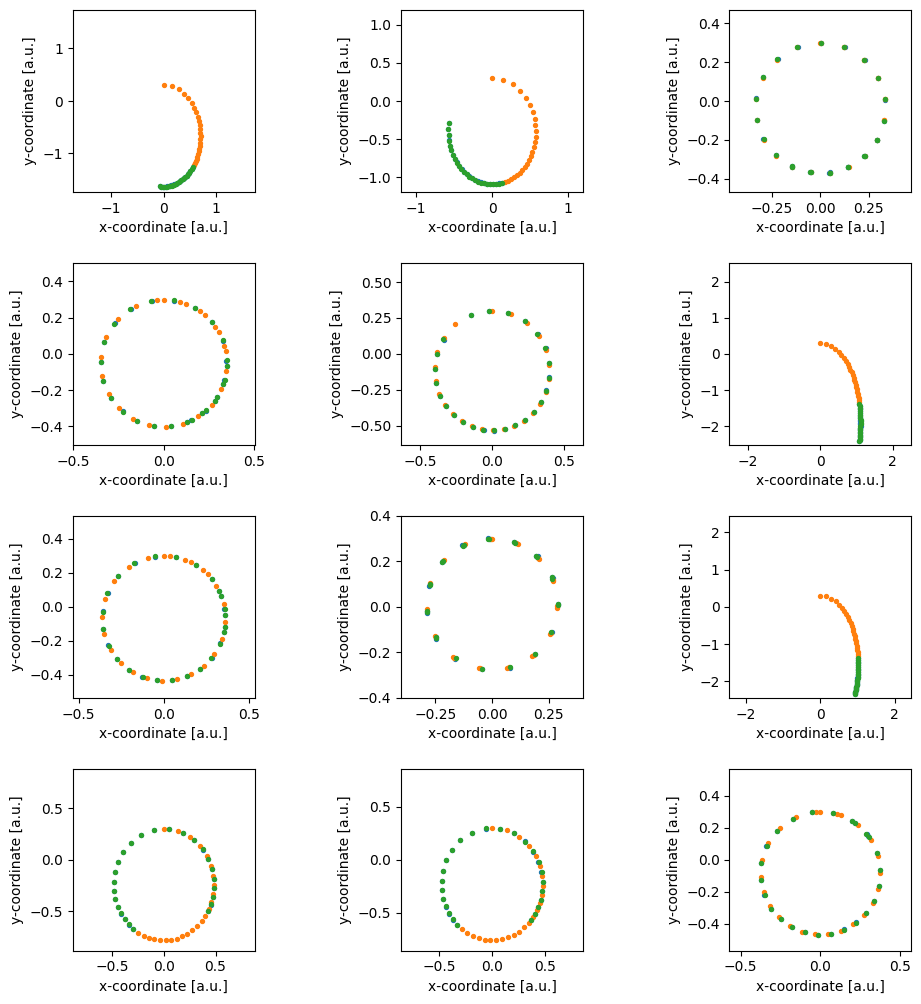

In [6]:
# Load saved model
loaded_model = tf.keras.saving.load_model('model_1000_samples_25_learned_timesteps.keras')

# Create test data
np.random.seed(44) # set seed for reproduceable test data
n_samples_test = 12 # number of samples to create for Dataset
test_data = tf.data.Dataset.from_generator(
    lambda: gen_samples_launch_from_surface(n_samples_test, n_timesteps), 
    output_signature=tf.TensorSpec(shape=(n_timesteps, 5))
)
test_data = test_data.map(lambda x: (x[:-n_target_steps, 1:3], x[-n_target_steps:, 1:3]))
test_data = test_data.cache()
test_data = test_data.batch(10)

# Calculate performance on test data
loss_eval = loaded_model.evaluate(test_data, verbose=0)
print(f'The loss on the test data is: {loss_eval:.2g}. This is of the same magnitude as observed on'
      'evaluation data during training.\n\n'
      'See the plots for different trajectories. Some are close to the planet in the origine with \n'
      'fast motion on an almost perfect circle (low eccentricity). Some are far away from the planet in\n'
      'in the origine, moving slowly and show more eccentricity.\nAll in common are well predicted by '
      'the model.')

# Plot test data with this model
iterator = test_data.unbatch().as_numpy_iterator()
fig, axes = plt.subplots(4, 3)
axes = axes.reshape(-1)
fig.set_size_inches(10, 10)
fig.tight_layout(h_pad=3)
for i, val in enumerate(iterator):
    prediction = loaded_model.predict(tf.expand_dims(val[0], 0), verbose=0)
    compare_trajectory(axes[i], prediction, val[0], val[1])

    The neuronal net successfully learned to complete the trajectories. This can either be seen at the low error on the test data, or visually confirmed by the plots, where the trajectories are meaningfully completed by the net's predictions.